## 单只绩效分析

In [1]:
from single_nav_analysis import NavAnalysisConfig, SingleNavAnalysis
from pathlib import Path
import numpy as np


nav_analysis_config = NavAnalysisConfig(
    bench_data_path=Path(r"C:\Euclid_Jie\barra\src\nav_analysis\index_data.csv"),
    # nav_data_path=Path(r"C:\Users\Ouwei\Desktop\管理人单页\SLD035-同温层量化阿尔法1号.xlsx"),
    nav_data_path=Path(
        r"C:\Users\Ouwei\Desktop\管理人单页\SLC732-同温层中证500指数增强1号.xlsx"
    ),
    # begin_date=np.datetime64("2023-12-29"),
    open_html=False,
    benchmark="SHSE.000905",
)
demo = SingleNavAnalysis(nav_analysis_config)
demo.analysis()
demo.export_html(save=True)
demo

开始读取SLC732-同温层中证500指数增强1号净值数据
原始数据时间区间为：2020-06-03 ~ 2024-09-20
本次统计时间区间为：2020-06-03 ~ 2024-09-20
html路径为：C:\Users\Ouwei\Desktop\管理人单页\20200603_20240920_SLC732-同温层中证500指数增强1号_nav_analysis.html


SLC732-同温层中证500指数增强1号净值分析[W]：2020-06-03 ~ 2024-09-20

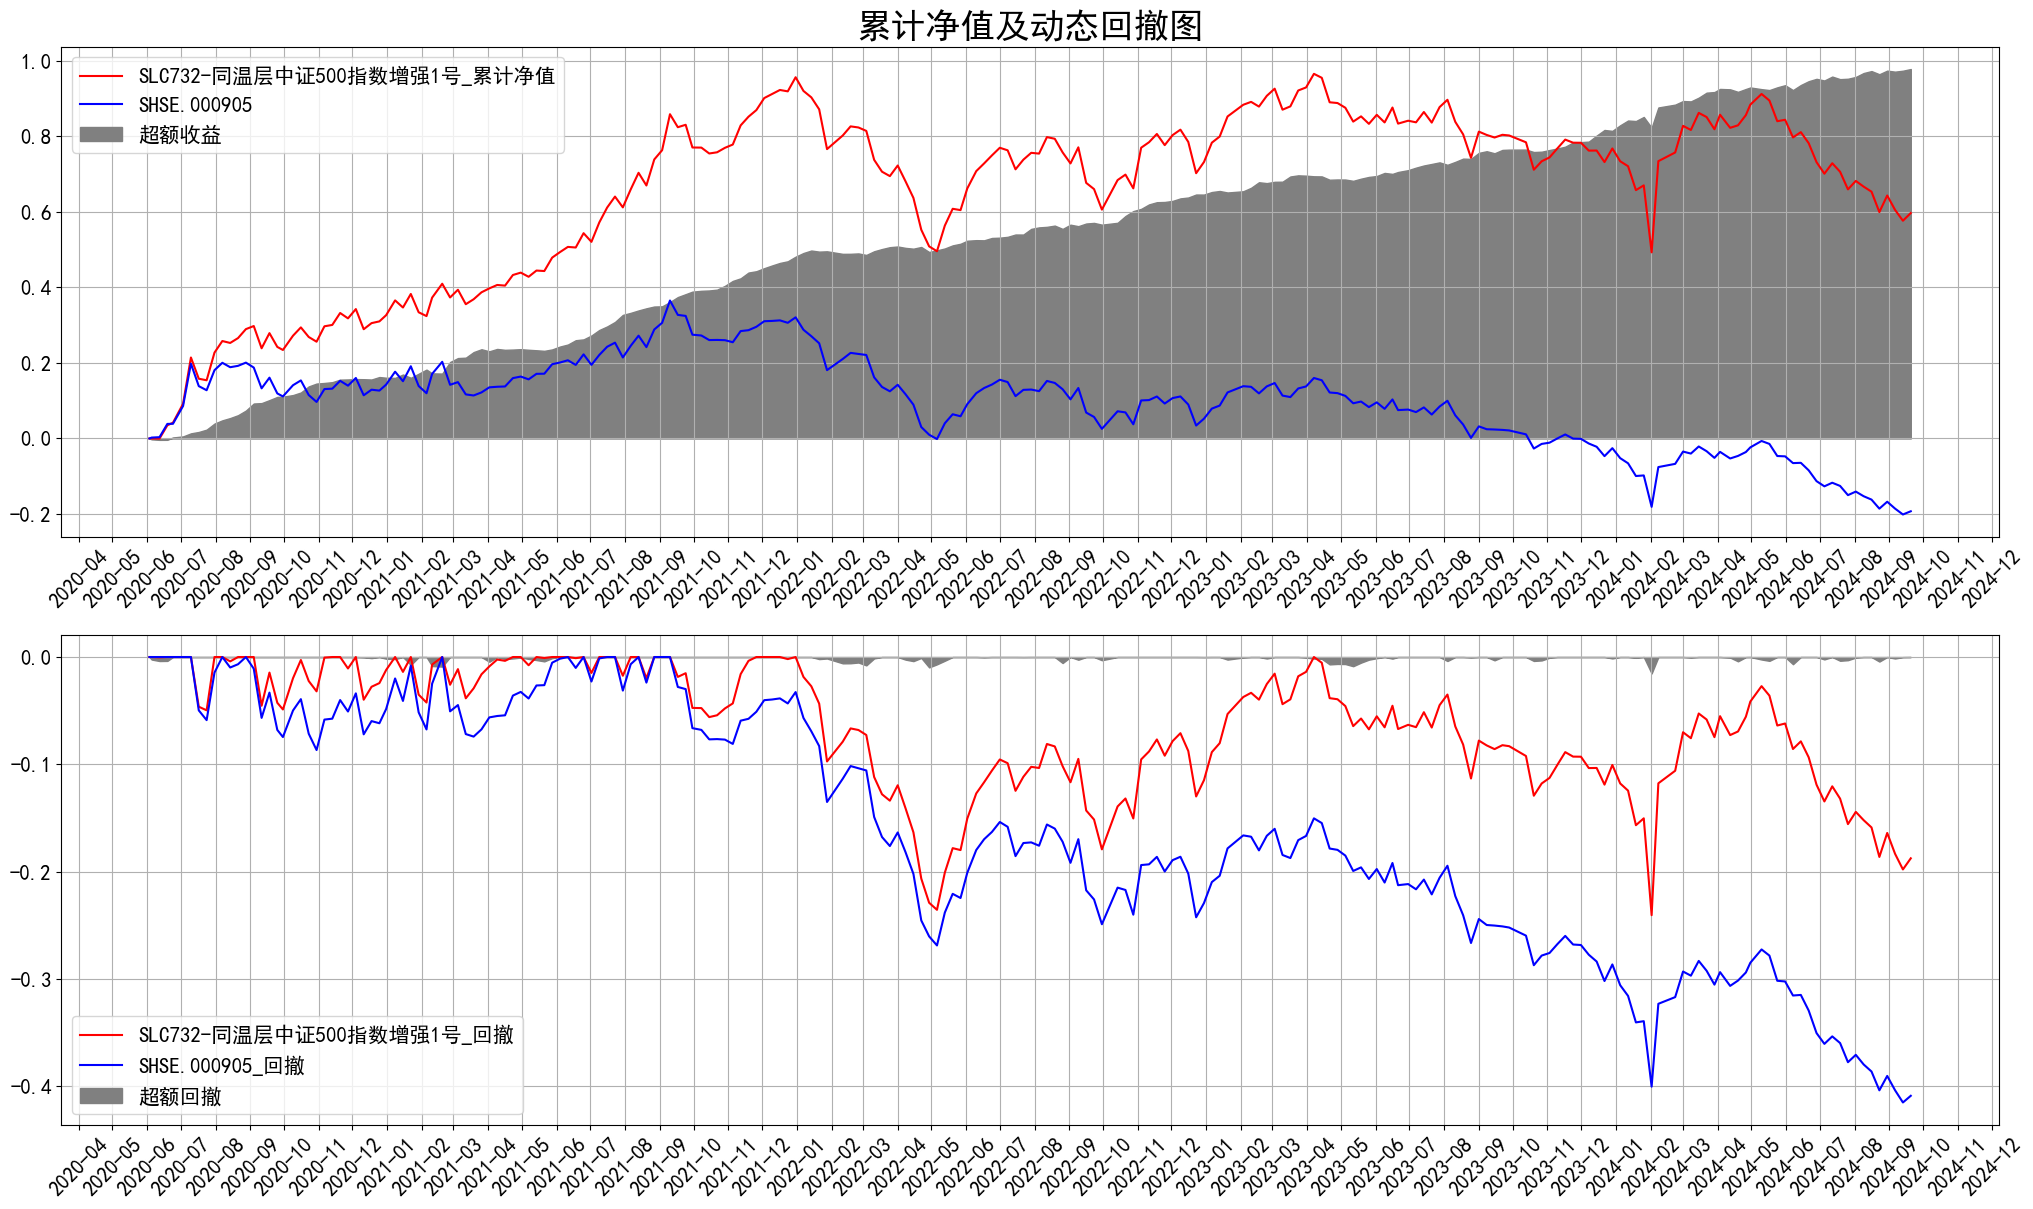

In [3]:
demo.plot("upper")

In [18]:
demo.monthly_rtn_df.to_csv(
    r"C:\Users\Ouwei\Desktop\monthly_rtn.csv", index=True, encoding="utf_8_sig"
)

## 自动生成index.html

In [19]:
from pathlib import Path


from pathlib import Path


def generate_index_html(folder_path: Path):
    # 获取目录及其子目录中的所有 HTML 文件
    html_files = folder_path.rglob("*.html")
    print(html_files)

    # 创建一个新的 index.html 文件
    with open(folder_path.joinpath("index.html"), "w", encoding="utf-8") as f:
        f.write(
            """<html>
<head>
<meta charset="UTF-8">
<title>Value over Time</title>
</head>
<body>"""
        )

        # 创建一个集合来存储已经处理过的文件夹，避免重复创建链接
        processed_folders = set()
        # 为每个 HTML 文件创建一个链接
        for html_file in html_files:
            if html_file.name == "index.html":
                continue
            relative_path = html_file.relative_to(folder_path)
            # 如果文件夹还没有被处理过，为文件夹创建一个链接
            if html_file.parent not in processed_folders:
                f.write(f"<h2><a>{html_file.parent.name}</a></h2>\n")
                processed_folders.add(html_file.parent)

            # 创建HTML文件的链接
            f.write(f'<a href="{relative_path}">{relative_path.name}</a><br/>\n')

        f.write("</body>\n</html>")


# 使用函数
generate_index_html(Path(r"C:\Euclid_Jie\barra\submodule\nav_analysis\docs"))

<generator object Path.rglob at 0x000001426E1679A0>


In [15]:
Path(r"C:\Euclid_Jie\barra\submodule\nav_analysis\docs\500增强\20180608_20240830_衍盛_nav_analysis.html").relative_to(Path(r"C:\Euclid_Jie\barra\submodule\nav_analysis\docs"))

WindowsPath('500增强/20180608_20240830_衍盛_nav_analysis.html')

## 双庆backword analysis 需求

In [19]:
from utils import backword_analysis
import pandas as pd

nav_data = pd.read_excel(r"C:\Users\Ouwei\Desktop\nav_data\0829双庆\nav_data.xlsx")
# 截取时间
nav_data = nav_data[nav_data["日期"] >= pd.to_datetime("2019-12-30")]
nav_data.set_index("日期", inplace=True)
nav_data = nav_data.ffill(limit_area="inside")

In [57]:
out = pd.DataFrame()
for name in nav_data.columns:
    single_nav_data = nav_data[name].reset_index(drop=False)
    single_nav_data = single_nav_data[~single_nav_data[name].isna()]
    if len(single_nav_data) < 10:
        continue
    res = backword_analysis(
        single_nav_data[name].values, single_nav_data["日期"].values, freq="W"
    ).reset_index(drop=False)
    res["产品"] = name
    out = pd.concat([out, res], axis=0)
out["策略类型"] = out["产品"].apply(lambda x: x.split("_")[-1])

In [58]:
out = out[out["backword months"].isin(["12M", "24M", "36M"])]
out = out[
    ["策略类型", "产品", "backword months", "年化收益率", "年化波动率", "夏普比率"]
]

,策略类型,产品,backword months,年化收益率,年化波动率,夏普比率
3,期现套利,0_博普日添月益_期现套利,12M,8.483%,1.395%,6.080
4,期现套利,0_博普日添月益_期现套利,24M,6.714%,1.348%,4.980
5,期现套利,0_博普日添月益_期现套利,36M,5.890%,1.717%,3.431
3,1000中性,0_麦迪生利锐联中性对冲1号_1000中性,12M,12.449%,5.925%,2.101
3,500指增,0_超量子中证500增强2号_500指增,12M,-5.693%,24.438%,-0.233
...,...,...,...,...,...,...
3,可转债套利,2_悬铃稳健金选1号_可转债套利,12M,-2.845%,7.960%,-0.357
3,指增,2_弈倍虎鲸_指增,12M,-13.005%,23.790%,-0.547
4,指增,2_弈倍虎鲸_指增,24M,-10.528%,20.929%,-0.503
5,指增,2_弈倍虎鲸_指增,36M,-5.651%,19.902%,-0.284


In [65]:
year = 1
res = pd.DataFrame()
for i in ["12M", "24M", "36M"]:
    data_i = out[out["backword months"] == i]
    data_i = data_i.drop("backword months", axis=1)
    data_i = data_i.rename(
        {
            "年化收益率": f"过去{year}_年化收益率",
            "年化波动率": f"过去{year}_年化波动率",
            "夏普比率": f"过去{year}_夏普比率",
        },
        axis=1,
    )
    year += 1
    res = pd.concat([res, data_i])

In [75]:
year = 3
data_i = out[out["backword months"] == "36M"]
data_i = data_i.drop("backword months", axis=1)
data_i = data_i.rename(
    {
        "年化收益率": f"过去{year}_年化收益率",
        "年化波动率": f"过去{year}_年化波动率",
        "夏普比率": f"过去{year}_夏普比率",
    },
    axis=1,
)

In [76]:
data_3 = data_i.copy()

In [78]:
res = data_1.merge(data_2, on=["策略类型", "产品"], how="left")

In [3]:
res = res.merge(data_3, on=["策略类型", "产品"], how="left")

NameError: name 'res' is not defined

In [80]:
res

,策略类型,产品,过去1_年化收益率,过去1_年化波动率,过去1_夏普比率,过去2_年化收益率,过去2_年化波动率,过去2_夏普比率,过去3_年化收益率,过去3_年化波动率,过去3_夏普比率
0,期现套利,0_博普日添月益_期现套利,8.483%,1.395%,6.080,6.714%,1.348%,4.980,5.890%,1.717%,3.431
1,1000中性,0_麦迪生利锐联中性对冲1号_1000中性,12.449%,5.925%,2.101,NaN,NaN,NaN,NaN,NaN,NaN
2,500指增,0_超量子中证500增强2号_500指增,-5.693%,24.438%,-0.233,-2.434%,21.189%,-0.115,-1.386%,19.925%,-0.070
3,混合中性,0_超量子量化中性1号_混合中性,5.290%,4.335%,1.220,NaN,NaN,NaN,NaN,NaN,NaN
4,其他多策略,0_岳皋华山一号_其他多策略,8.214%,5.841%,1.406,NaN,NaN,NaN,NaN,NaN,NaN
5,其他多策略,0_岳皋泰山核心一号_其他多策略,5.742%,2.811%,2.042,6.145%,2.887%,2.129,NaN,NaN,NaN
6,混合中性,1_磐松市场中性进取1号_混合中性,30.651%,18.409%,1.665,NaN,NaN,NaN,NaN,NaN,NaN
7,主观CTA复合,1_草本优益1号_主观CTA复合,6.423%,11.164%,0.575,18.755%,15.280%,1.227,13.062%,16.105%,0.811
8,500中性,1_衍复春晓一期_500中性,11.074%,11.108%,0.997,7.048%,8.254%,0.854,7.617%,7.352%,1.036
9,1000中性,1_倍漾优博一号_1000中性,12.721%,11.295%,1.126,10.464%,9.162%,1.142,NaN,NaN,NaN


In [68]:
res.sort_values(["策略类型", "产品"]).to_csv(
    r"C:\Users\Ouwei\Desktop\res_backword_analysis.csv",
    index=False,
    encoding="utf_8_sig",
)

In [ ]:
out.to_csv(
    r"C:\Users\Ouwei\Desktop\backword_analysis.csv", index=False, encoding="utf-8-sig"
)

## 多只对比

In [1]:
from compare_nav_analysis import NavAnalysisConfig, CompareNavAnalysis
from pathlib import Path
import numpy as np

nav_analysis_config = NavAnalysisConfig(
    bench_data_path=Path(r"C:\Euclid_Jie\barra\src\nav_analysis\index_data.csv"),
    nav_data_path=[
        Path(r"C:\Users\Ouwei\Desktop\管理人单页\SLD035-同温层量化阿尔法1号.xlsx"),
        Path(r"C:\Users\Ouwei\Desktop\管理人单页\STC996-永誉天泽经纶二号.xlsx"),
    ],
    begin_date=np.datetime64("2023-12-31"),
    # end_date=np.datetime64("2024-06-07"),
    open_html=False,
    # benchmark="SHSE.000852",
)
demo = CompareNavAnalysis(nav_analysis_config)
demo.anlysis()
demo.export_html(save=True)

SLD035-同温层量化阿尔法1号，原始数据时间区间为：2020-05-25 - 2024-09-20
STC996-永誉天泽经纶二号，原始数据时间区间为：2021-11-15 - 2024-09-20
本次统计时间区间为：2024-01-05 ~ 2024-09-20
开始读取SLD035-同温层量化阿尔法1号净值数据
原始数据时间区间为：2020-05-25 ~ 2024-09-20
本次统计时间区间为：2024-01-05 ~ 2024-09-20
开始读取STC996-永誉天泽经纶二号净值数据
原始数据时间区间为：2021-11-15 ~ 2024-09-20
本次统计时间区间为：2024-01-05 ~ 2024-09-20
html路径为：C:\Users\Ouwei\Desktop\管理人单页\20240105_20240920_compare_nav_analysis.html


In [3]:
demo.weekly_rtn_df

日期,2024-07-19,2024-07-26,2024-08-02,2024-08-09,2024-08-16,2024-08-23,2024-08-30,2024-09-06,2024-09-13,2024-09-20
SLD035-同温层量化阿尔法1号_周收益,-0.0021,0.0013,-0.0056,0.0055,0.0019,-0.0037,-0.0035,0.0065,-0.0015,0.0082
STC996-永誉天泽经纶二号_周收益,-0.0049,-0.0033,-0.0082,-0.0016,0.0033,-0.0008,-0.0141,0.0116,-0.0025,0.0033
